# Download data

In [3]:
import pandas as pd
from datetime import timedelta, datetime
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import pickle

In [11]:
from datetime import date

In [4]:
COLUMNS_COVID_USABLE = ['new_cases', 'new_deaths', 'location']


def download_whole_covid_data():
    data = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', index_col='date', parse_dates=True)
    data = data[COLUMNS_COVID_USABLE]
    global COVID_DATA
    COVID_DATA = data


def download_whole_data():
    download_whole_covid_data()

In [5]:
download_whole_data()

In [6]:
COVID_DATA.head()

,new_cases,new_deaths,location
date,,,
2020-02-24,1.0,NaN,Afghanistan
2020-02-25,0.0,NaN,Afghanistan
2020-02-26,0.0,NaN,Afghanistan
2020-02-27,0.0,NaN,Afghanistan
2020-02-28,0.0,NaN,Afghanistan


# Predictions - preparation

In [7]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import numpy as np
from sklearn.preprocessing import StandardScaler

gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

basic data preparation

In [136]:
COVID_DATA.columns

Index(['new_cases', 'new_deaths', 'location'], dtype='object')

In [137]:
new_cases_pl = COVID_DATA[COVID_DATA['location'] == 'Poland']['new_cases']
new_deaths_pl = COVID_DATA[COVID_DATA['location'] == 'Poland']['new_deaths']

new_deaths_pl.fillna(0, inplace=True)

/home/matmozaur/.local/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


<AxesSubplot:xlabel='date'>

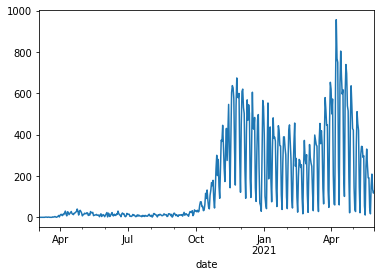

In [138]:
new_deaths_pl.plot()

<AxesSubplot:xlabel='date'>

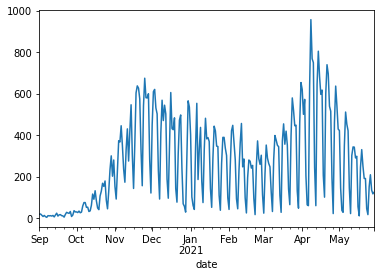

In [139]:
new_deaths_pl['2020-09-01':].plot()

In [140]:
new_deaths_pl = new_deaths_pl['2020-09-01':]

<AxesSubplot:xlabel='date'>

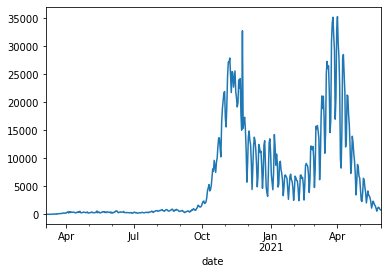

In [141]:
new_cases_pl.plot()

<AxesSubplot:xlabel='date'>

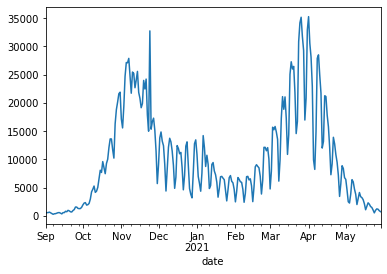

In [142]:
new_cases_pl['2020-09-01':].plot()

In [143]:
new_cases_pl = new_cases_pl['2020-09-01':]

Deal with seasonality

In [144]:
from statsmodels.tsa.seasonal import seasonal_decompose

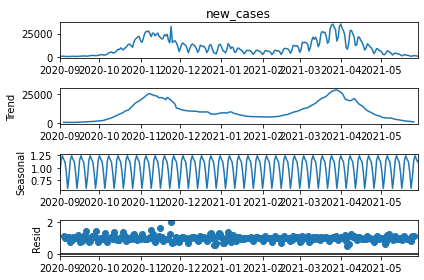

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

In [145]:
result = seasonal_decompose(new_cases_pl, model='multiplicative', period=7)
result.plot()
plt.show()

plt.figure(figsize=(10,3))

In [146]:
new_cases_pl_seasonal = result.seasonal
new_cases_pl = new_cases_pl/result.seasonal

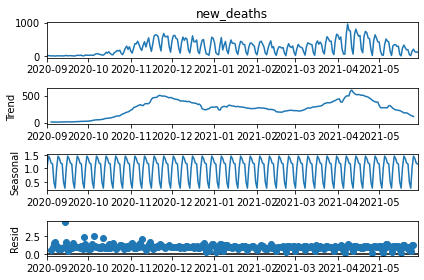

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

In [147]:
result = seasonal_decompose(new_deaths_pl, model='multiplicative', period=7)
result.plot()
plt.show()

plt.figure(figsize=(10,3))

In [148]:
new_deaths_pl_seasonal = result.seasonal
new_deaths_pl = new_deaths_pl/result.seasonal

Rescaling and train-test split

In [149]:
new_cases_scaler = StandardScaler()

new_cases_pl_2 = new_cases_scaler.fit_transform(new_cases_pl.values.reshape(-1, 1))

new_cases_pl_2 = new_cases_pl_2.reshape(-1)

In [150]:
new_deaths_scaler = StandardScaler()

new_deaths_pl_2 = new_deaths_scaler.fit_transform(new_deaths_pl.values.reshape(-1, 1))

new_deaths_pl_2 = new_deaths_pl_2.reshape(-1)

In [151]:
def prepare_data(data, n_future = 1, n_past = 14):
    x_train = []
    y_train = []
    for i in range(0, len(data) - n_past - n_future + 1):
        x_train.append(data[i : i + n_past])
        y_train.append(data[i + n_past : i + n_past + n_future])

    x_train , y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0] , x_train.shape[1], 1))
    return x_train, y_train

In [22]:
new_cases_x, new_cases_y = prepare_data(new_cases_pl_2, n_future=7)

In [23]:
new_cases_X_train, new_cases_X_test, new_cases_y_train, new_cases_y_test =\
    train_test_split(new_cases_x, new_cases_y, test_size=0.2, shuffle=False)


In [24]:
new_deaths_x, new_deaths_y = prepare_data(new_deaths_pl_2, n_future=7)

In [25]:
new_deaths_X_train, new_deaths_X_test, new_deaths_y_train, new_deaths_y_test =\
    train_test_split(new_deaths_x, new_deaths_y, test_size=0.2, shuffle=False)


# Predictions 

In [21]:
def prepare_one_dim_LSTM(x_train, n_future, lstm_units=200, dropout=0.1, dense_neurons=[70],
                         dense_activation='relu', optimizer='adam',
                         loss='mean_absolute_error'):
    regressor = Sequential()
    regressor.add(Bidirectional(LSTM(units=lstm_units,
                                     input_shape = (x_train.shape[1], 1))))
    for d_n in dense_neurons:
        regressor.add(Dense(d_n, activation=dense_activation))
        
    regressor.add(Dense(units = n_future, activation='linear'))
    regressor.compile(
    optimizer=optimizer, 
    loss=loss)
    return regressor

new cases

In [153]:
regressor = prepare_one_dim_LSTM(new_cases_x, 7)

In [154]:
regressor.fit(new_cases_X_train, new_cases_y_train,
              validation_data=(new_cases_X_test, new_cases_y_test), epochs=200, batch_size=32)

Epoch 1/200
7/7 [==============================] - 0s 67ms/step - loss: 0.6479 - val_loss: 0.4975
Epoch 2/200
7/7 [==============================] - 0s 7ms/step - loss: 0.4689 - val_loss: 0.6022
Epoch 3/200
7/7 [==============================] - 0s 8ms/step - loss: 0.3990 - val_loss: 0.4632
Epoch 4/200
7/7 [==============================] - 0s 8ms/step - loss: 0.3527 - val_loss: 0.4537
Epoch 5/200
7/7 [==============================] - 0s 8ms/step - loss: 0.3228 - val_loss: 0.4062
Epoch 6/200
7/7 [==============================] - 0s 8ms/step - loss: 0.2880 - val_loss: 0.3126
Epoch 7/200
7/7 [==============================] - 0s 8ms/step - loss: 0.2672 - val_loss: 0.3187
Epoch 8/200
7/7 [==============================] - 0s 7ms/step - loss: 0.2622 - val_loss: 0.3014
Epoch 9/200
7/7 [==============================] - 0s 8ms/step - loss: 0.2609 - val_loss: 0.2872
Epoch 10/200
7/7 [==============================] - 0s 7ms/step - loss: 0.2667 - val_loss: 0.3395
Epoch 11/200
7/7 [==========

KeyboardInterrupt: 

In [52]:
a = regressor.predict(new_cases_X_test)

a = new_cases_scaler.inverse_transform(a)

b = new_cases_scaler.inverse_transform(new_cases_y_test)

In [54]:
a_7 = a[:,6]
b_7 = b[:,6]

In [55]:
print("{:.2f}".format(sum(abs(a_7 - b_7))/len(a_7)))

1795.78


In [56]:
a_7 *= new_cases_pl_seasonal.values[-len(a_7):]
b_7 *= new_cases_pl_seasonal.values[-len(a_7):]

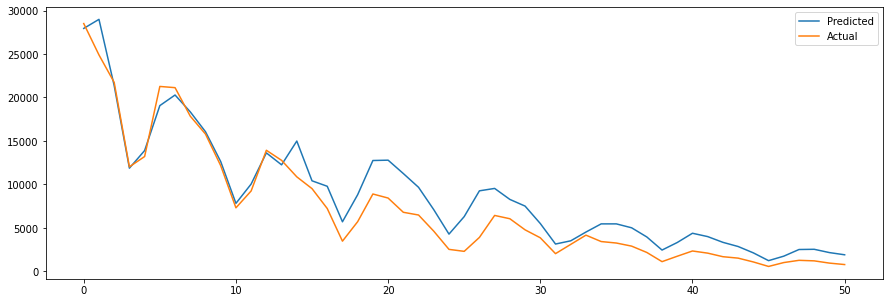

In [57]:
plt.figure(figsize=(15,5))
plt.plot(a_7, label="Predicted")
plt.plot(b_7, label="Actual")
plt.legend()

In [58]:
print("{:.2f}".format(sum(abs(a_7 - b_7))/len(a_7)))

1794.41


In [62]:
regressor.save_weights('data/new_cases_lstm.h5')

In [64]:
with open('data/new_cases_scaler.pickle', 'wb') as handle:
    pickle.dump(new_cases_scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [81]:
new_cases_pl_seasonal.index[0]

Timestamp('2020-09-01 00:00:00')

In [84]:
date.weekday(new_cases_pl_seasonal.index[6])

0

In [87]:
new_cases_pl_seasonal[6:13]

date
2020-09-07    0.587318
2020-09-08    0.818013
2020-09-09    1.153671
2020-09-10    1.243704
2020-09-11    1.170887
2020-09-12    1.120632
2020-09-13    0.905775
Name: seasonal, dtype: float64

In [88]:
with open('data/new_cases_seasonal.pickle', 'wb') as handle:
    pickle.dump(new_cases_pl_seasonal[6:13], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [89]:
regressor.predict(new_cases_X_test[0].reshape(1,14,1))

array([[1.9725055 , 1.570849  , 1.3711791 , 0.9065841 , 0.42259872,
        0.7159083 , 1.6330702 ]], dtype=float32)

new deaths

In [96]:
regressor = prepare_one_dim_LSTM(new_deaths_x, 7, lstm_units=100)

In [97]:
regressor.fit(new_deaths_X_train, new_deaths_y_train,
              validation_data=(new_deaths_X_test, new_deaths_y_test), epochs=50, batch_size=32)

Epoch 1/50
7/7 [==============================] - 0s 69ms/step - loss: 0.6501 - val_loss: 0.7941
Epoch 2/50
7/7 [==============================] - 0s 7ms/step - loss: 0.4850 - val_loss: 0.7265
Epoch 3/50
7/7 [==============================] - 0s 6ms/step - loss: 0.4482 - val_loss: 0.6874
Epoch 4/50
7/7 [==============================] - 0s 7ms/step - loss: 0.4206 - val_loss: 0.6977
Epoch 5/50
7/7 [==============================] - 0s 7ms/step - loss: 0.4065 - val_loss: 0.6822
Epoch 6/50
7/7 [==============================] - 0s 6ms/step - loss: 0.3947 - val_loss: 0.6713
Epoch 7/50
7/7 [==============================] - 0s 7ms/step - loss: 0.3817 - val_loss: 0.6616
Epoch 8/50
7/7 [==============================] - 0s 7ms/step - loss: 0.3714 - val_loss: 0.6565
Epoch 9/50
7/7 [==============================] - 0s 7ms/step - loss: 0.3638 - val_loss: 0.6418
Epoch 10/50
7/7 [==============================] - 0s 7ms/step - loss: 0.3572 - val_loss: 0.6317
Epoch 11/50
7/7 [=====================

In [98]:
a = regressor.predict(new_deaths_X_test)

a = new_deaths_scaler.inverse_transform(a)

b = new_deaths_scaler.inverse_transform(new_deaths_y_test)

In [99]:
a_7 = a[:,6]
b_7 = b[:,6]

In [100]:
print("{:.2f}".format(sum(abs(a_7 - b_7))/len(a_7)))

95.53


In [105]:
regressor.save_weights('data/new_deaths_lstm.h5')

In [108]:
with open('data/new_deaths_scaler.pickle', 'wb') as handle:
    pickle.dump(new_deaths_scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [109]:
with open('data/new_deaths_seasonal.pickle', 'wb') as handle:
    pickle.dump(new_deaths_pl_seasonal[6:13], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
    today = datetime.now()
    time_prior = today - timedelta(days=15)
    new_cases_pl = COVID_DATA[COVID_DATA['location'] == 'Poland']['new_cases']
    new_deaths_pl = COVID_DATA[COVID_DATA['location'] == 'Poland']['new_deaths']
    new_cases_pl = new_cases_pl[new_cases_pl.index >= time_prior]
    new_deaths_pl = new_deaths_pl[new_deaths_pl.index >= time_prior]
    with open('data/new_deaths_scaler.pickle', 'rb') as fp:
        new_deaths_scaler = pickle.load(fp)
    with open('data/new_cases_scaler.pickle', 'rb') as fp:
        new_cases_scaler = pickle.load(fp)
    with open('data/new_deaths_seasonal.pickle', 'rb') as fp:
        new_deaths_pl_seasonal = pickle.load(fp)
    with open('data/new_cases_seasonal.pickle', 'rb') as fp:
        new_cases_pl_seasonal = pickle.load(fp)
    day = date.weekday(new_cases_pl.index[0])
    new_cases_pl_seasonal2 = np.concatenate((new_cases_pl_seasonal.values[day:],
                                             new_cases_pl_seasonal.values[:day]))
    new_cases_pl_seasonal2 = np.concatenate((new_cases_pl_seasonal2,
                                             new_cases_pl_seasonal2))
    new_cases_x = new_cases_pl.values[-14:]/new_cases_pl_seasonal2
    new_cases_x = new_cases_scaler.transform(new_cases_x.reshape(-1,1))
    new_cases_x = new_cases_x.reshape(-1)
    new_cases_x = new_cases_x.reshape(1,14,1)
    regressor = prepare_one_dim_LSTM(new_cases_x, 7)
    regressor.build(input_shape=(1, 14, 1))
    regressor.load_weights('data/new_cases_lstm.h5')
    pred = regressor.predict(new_cases_x)
    pred = new_cases_scaler.inverse_transform(pred)
    day = date.weekday(new_cases_pl.index[-1])
    day = (day+1)%7
    new_cases_pl_seasonal = np.concatenate((new_cases_pl_seasonal.values[day:],
                                            new_cases_pl_seasonal.values[:day]))
    pred *= new_cases_pl_seasonal
    idx = [new_cases_pl.index[-1] +timedelta(days=i) for i in range(1,8)]
    pred = pd.Series(pred.reshape(-1), index=idx)

In [31]:
# pd.concat((new_cases_pl, pred))

[]

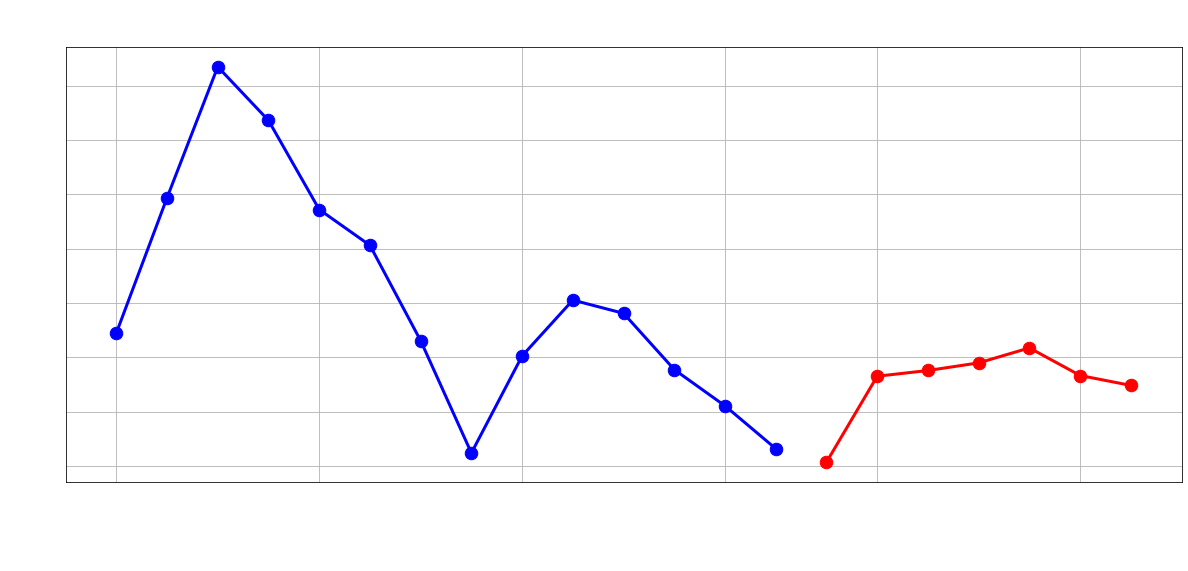

In [40]:
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    ax.plot(new_cases_pl, 'b.-', markersize=25, linewidth=3)
    ax.plot(pred, 'r.-', markersize=25, linewidth=3)
    ax.grid()
    plt.xticks(rotation=30, )
    plt.title("LSTM prediction for new cases in Poland",
              fontdict={'fontsize': 40, 'color': "white"})
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.xaxis.label.set_fontsize(30)
    ax.yaxis.label.set_fontsize(30)
    ax.tick_params(colors='white')
    ax.plot()